e:\Project\AI\Nutrition\foodENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to C:\Users\Kero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
e:\Project\AI\Nutrition\foodENV\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
e:\Project\AI\Nutrition\foodENV\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BartForConditionalGenera

Starting with 9882 recipes in dataset
Processed Query: "I want a recipe with high magnesium and low carbohydrates" 

Final Lists After Combining Disease + User Query:
Ingredients to include: []
Ingredients to exclude: []
Nutrition conditions to include: [('high', 'Magnesium'), ('low', 'Carbohydrate')]
Nutrition conditions to exclude: []
Starting with 9882 recipes for filtering
After applying nutrition condition 1 (include) '('high', 'Magnesium')': 1396 recipes remain (removed 8486)
After applying nutrition condition 2 (include) '('low', 'Carbohydrate')': 161 recipes remain (removed 1235)

Recommended Meal:
Meal name: Taco Beans
NER: ["green chilies", "cumin", "tomatoes", "bell pepper", "chili powder", "garlic", "taco sauce", "onions", "pinto beans", "ground meat"]
Nutrition details: {'calories': 1892.0, 'Total fats': 23.83, 'Carbohydrate': 105.74, 'Fiber': 19.4, 'Protein': 24.44, 'Cholesterol': 0.0, 'Calcium': 1657.0, 'Iron': 68.79, 'Magnesium': 386.0, 'Potassium': 2076.0, 'Sodium': 56

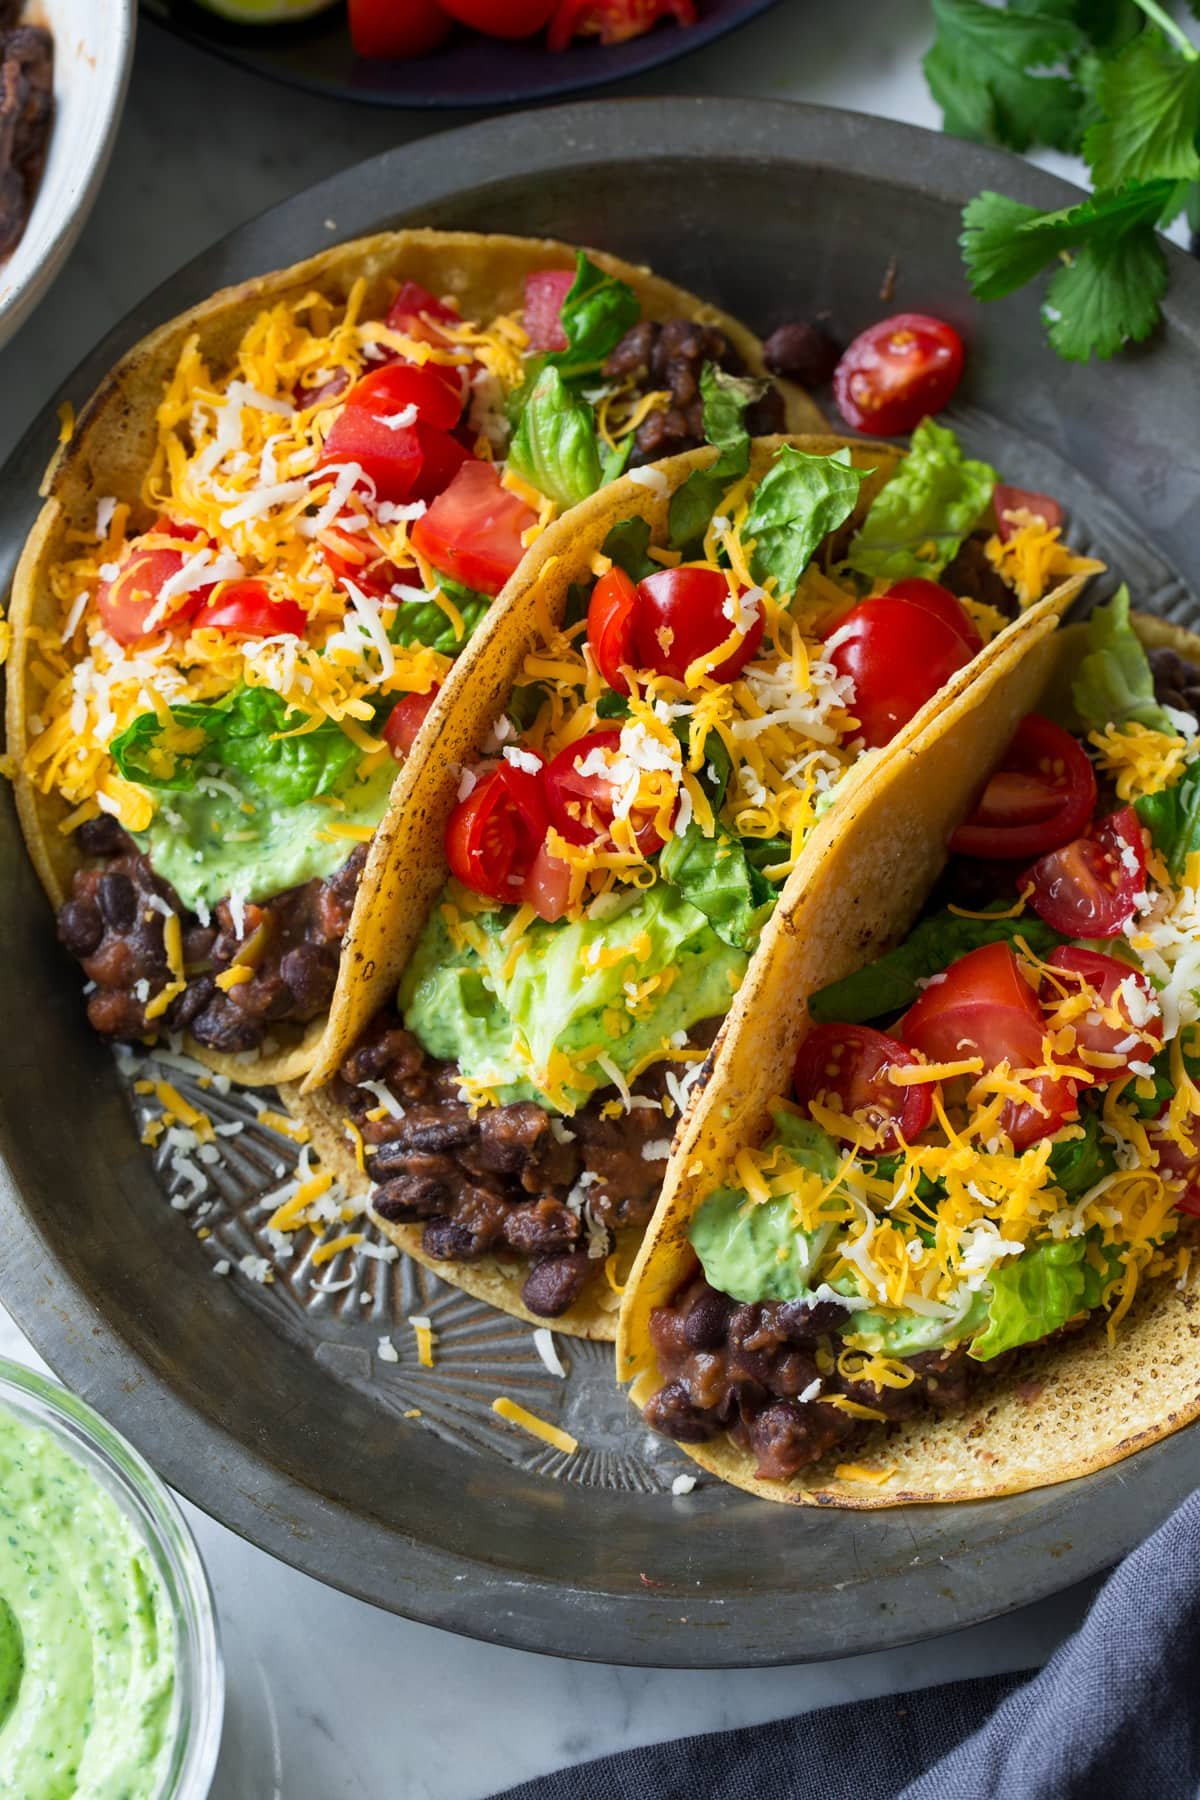


Additional options you might like:

Option 1:
Meal name: Thai Ribbons
NER: ["ginger", "teriyaki sauce", "beef flank", "red pepper", "clove garlic", "vegetable oil"]
Nutrition details: {'calories': 2407.0, 'Total fats': 145.12, 'Carbohydrate': 86.42, 'Fiber': 35.8, 'Protein': 15.47, 'Cholesterol': 39.0, 'Calcium': 836.0, 'Iron': 14.14, 'Magnesium': 320.0, 'Potassium': 1245.0, 'Sodium': 4735.0, 'Vitamin C': 6.6000000000000005}


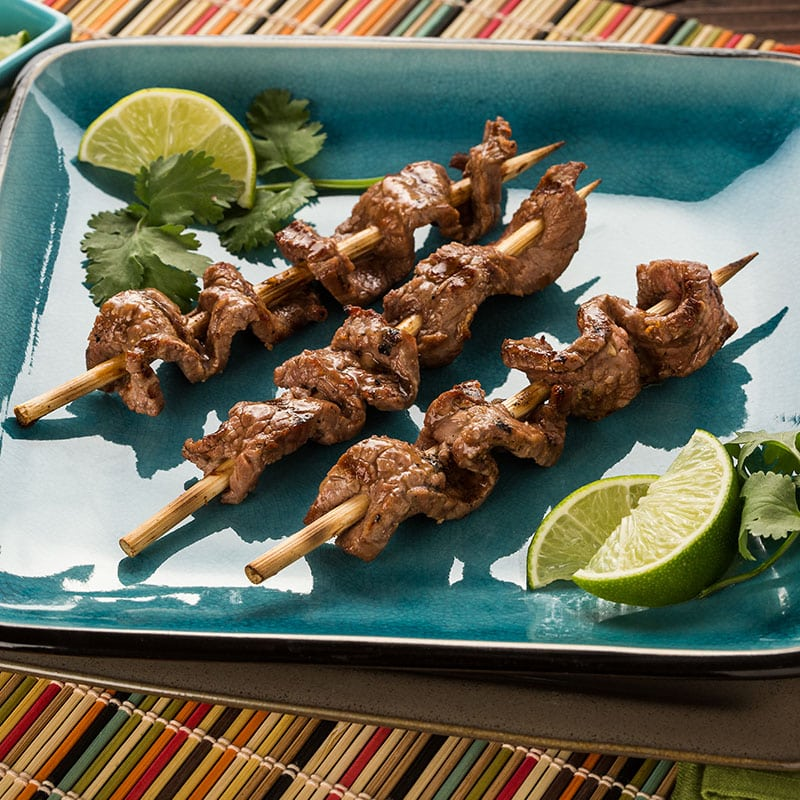


Option 2:
Meal name: Cold Lo Mein Salad
NER: ["sesame seed", "red wine vinegar", "soy sauce", "parsley flakes", "sesame oil", "garlic", "mustard", "vegetable oil"]
Nutrition details: {'calories': 2030.0, 'Total fats': 203.95, 'Carbohydrate': 43.53, 'Fiber': 5.1, 'Protein': 12.39, 'Cholesterol': 0.0, 'Calcium': 763.0, 'Iron': 3.04, 'Magnesium': 122.0, 'Potassium': 585.0, 'Sodium': 6593.0, 'Vitamin C': 80.4}


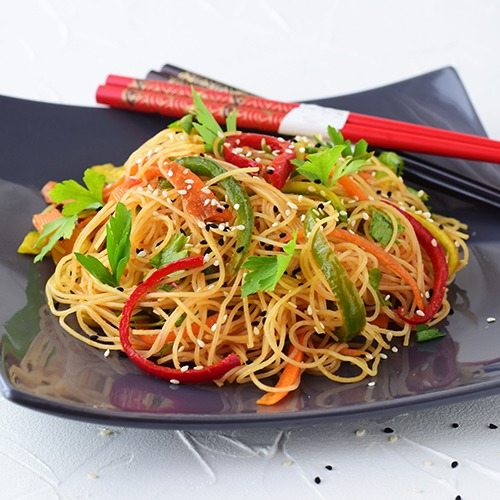


Option 3:
Meal name: Out-A-Sight Chicken
NER: ["cabbage", "chicken breasts", "soy", "mushrooms", "water", "onions", "wine", "zucchini"]
Nutrition details: {'calories': 703.0, 'Total fats': 10.12, 'Carbohydrate': 82.39999999999999, 'Fiber': 9.2, 'Protein': 47.93, 'Cholesterol': 53.0, 'Calcium': 253.0, 'Iron': 9.36, 'Magnesium': 200.0, 'Potassium': 659.0, 'Sodium': 1672.0, 'Vitamin C': 21.9}


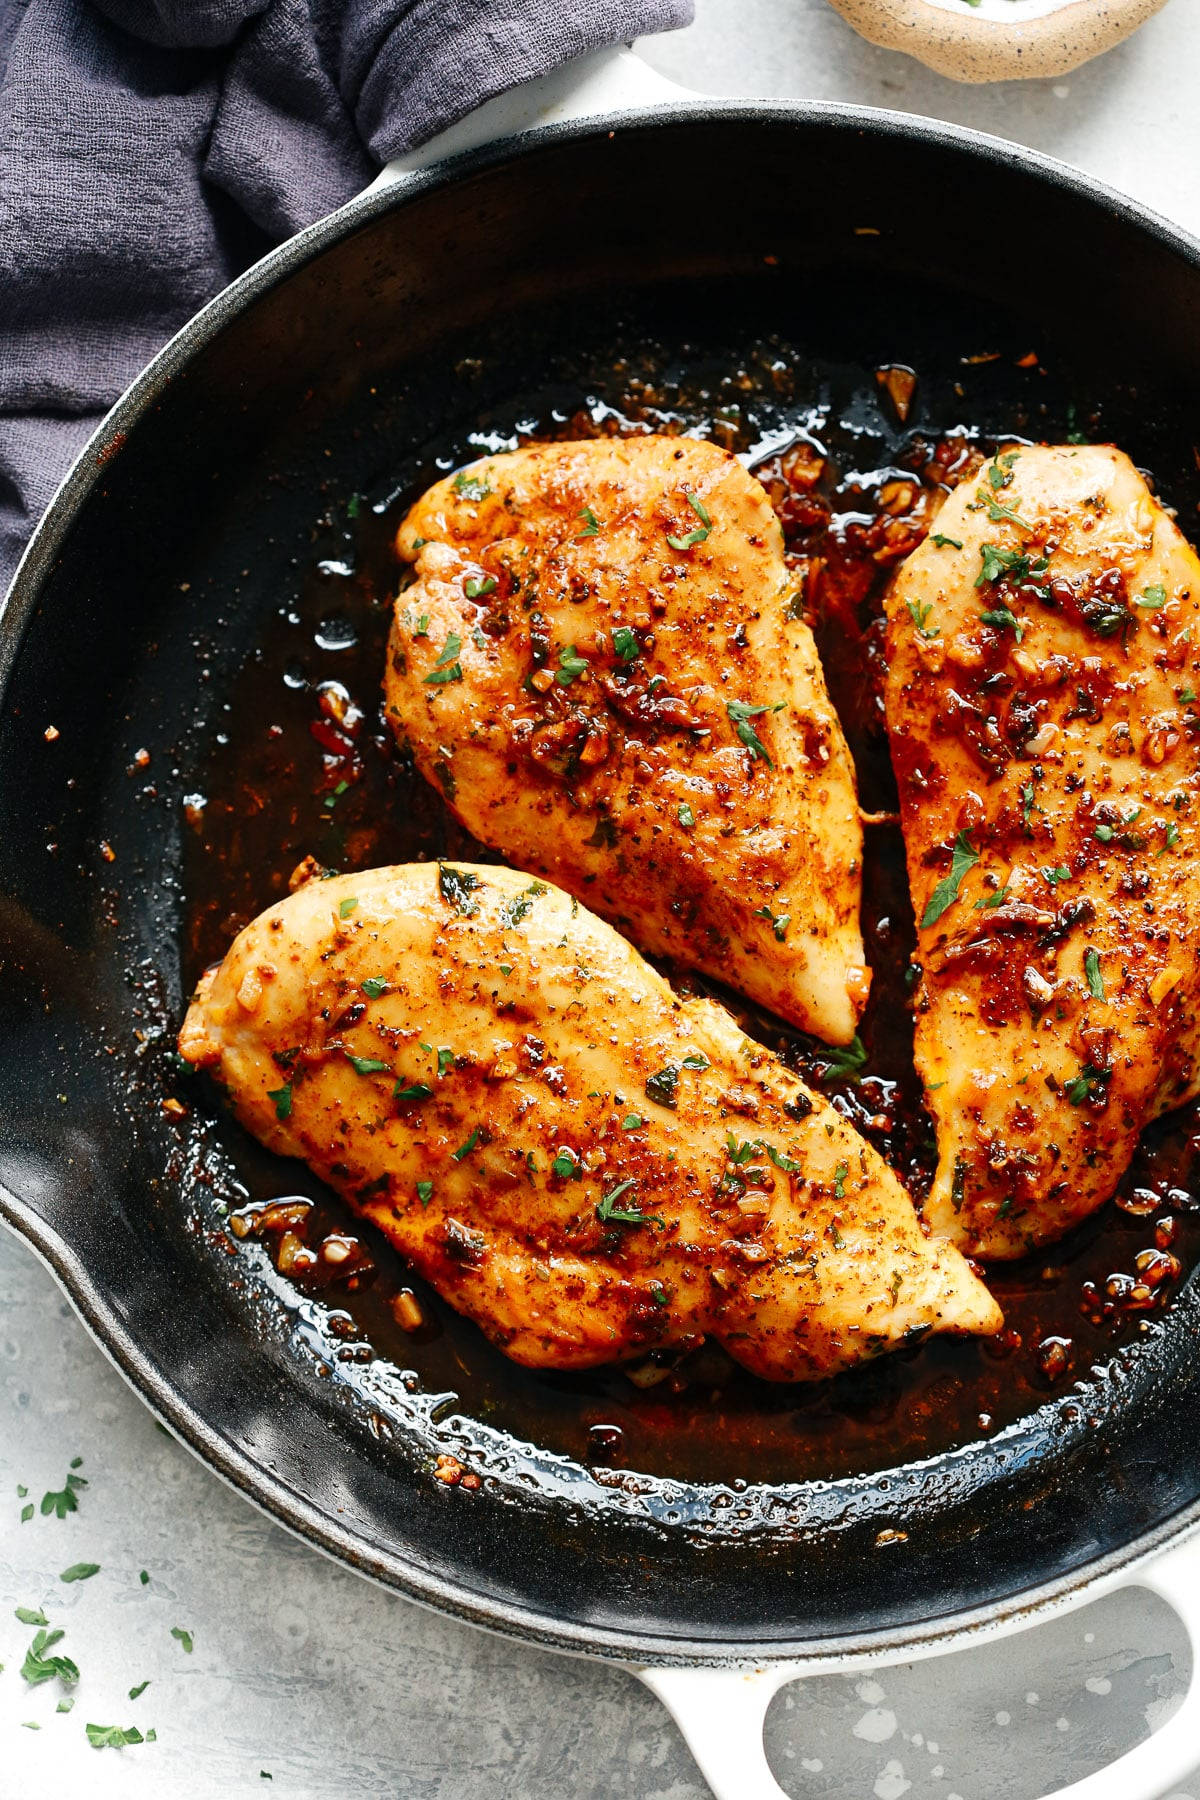


Option 4:
Meal name: Bean And Bacon Soup
NER: ["tomatoes", "celery", "clove garlic", "red onion", "olive oil", "crisp"]
Nutrition details: {'calories': 2255.0, 'Total fats': 122.59, 'Carbohydrate': 95.68, 'Fiber': 36.6, 'Protein': 8.78, 'Cholesterol': 23.0, 'Calcium': 648.0, 'Iron': 13.36, 'Magnesium': 289.0, 'Potassium': 1140.0, 'Sodium': 398.0, 'Vitamin C': 0.8}


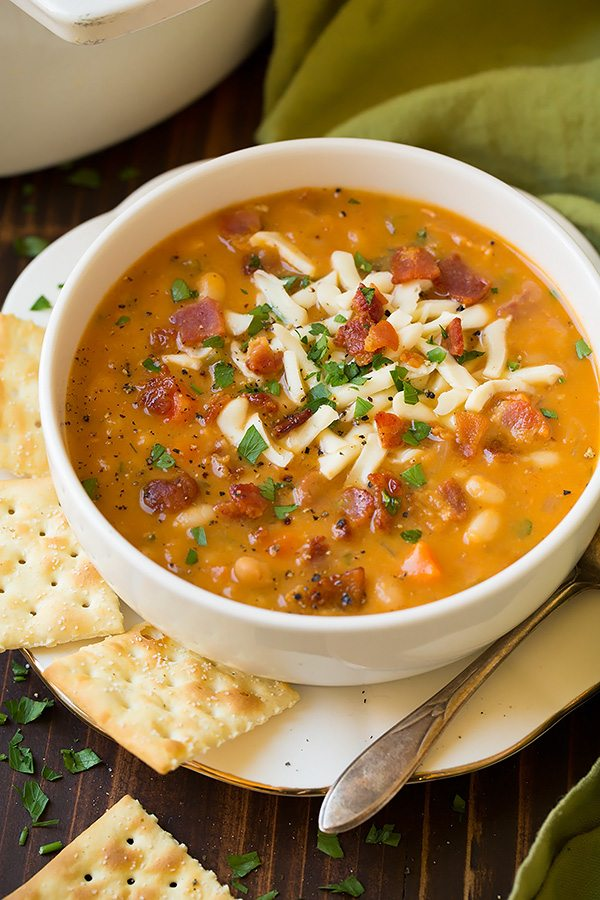


Option 5:
Meal name: B L T Salad Toss
NER: ["shredded lettuce", "crisply cooked bacon", "tomato halves", "celery", "onion rings", "salad dressing", "green pepper"]
Nutrition details: {'calories': 1475.0, 'Total fats': 182.16, 'Carbohydrate': 92.86, 'Fiber': 11.49, 'Protein': 50.32000000000001, 'Cholesterol': 154.0, 'Calcium': 166.8, 'Iron': 7.35, 'Magnesium': 139.0, 'Potassium': 1078.0, 'Sodium': 3271.0, 'Vitamin C': 85.3}


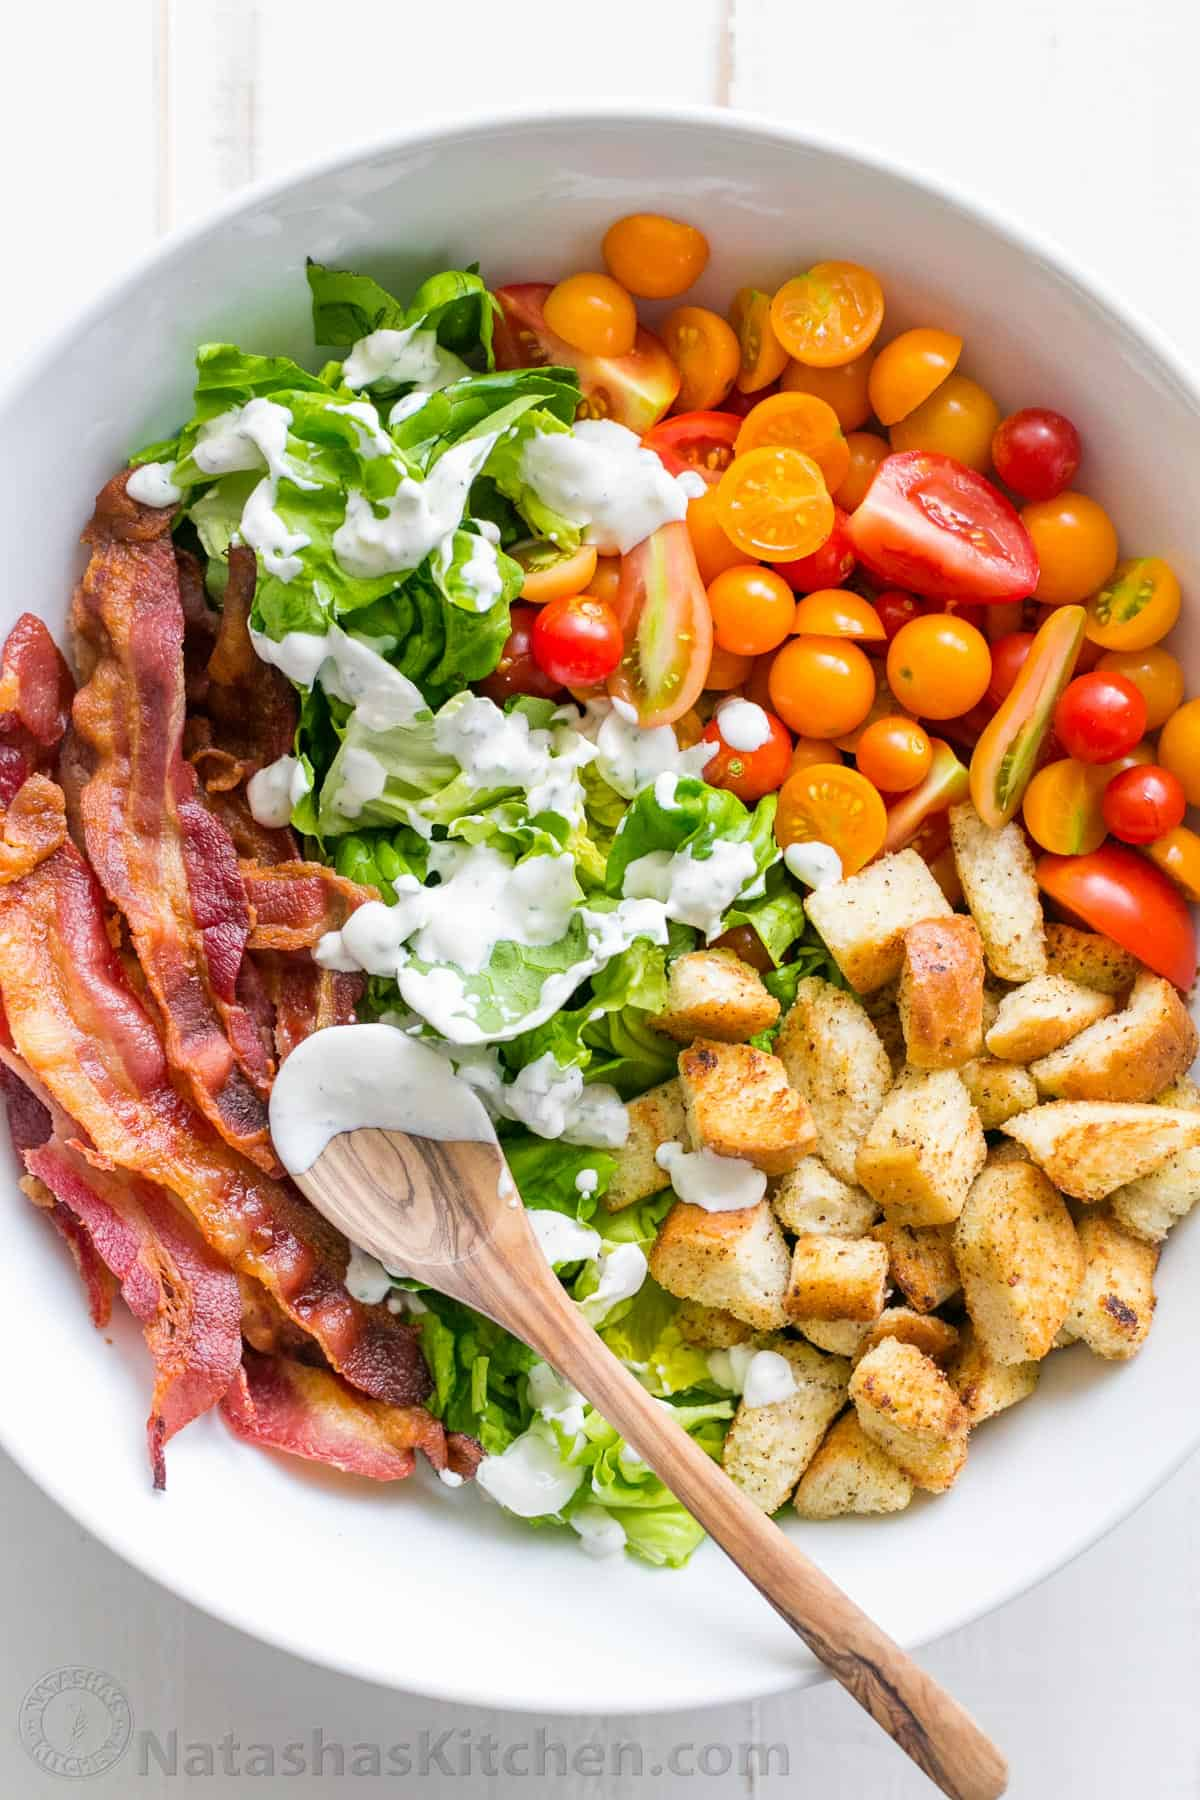

In [1]:
import pandas as pd
from transformers import pipeline
import os
import re
import json
from IPython.display import Image, display
from difflib import get_close_matches
from textblob import TextBlob
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import ast  

nltk.download('punkt')
domain_words = {
    "carb", "carbs", "carbo", "carbohydrate", "carbohydrates",
    "fat", "fats", "protein", "proteins", "fiber", "cholesterol",
    "calcium", "iron", "magnesium", "potassium", "sodium", "vitamin", "vitamin c",
    "calories", "calorie"
}

def smart_correct_spelling(text, domain_set):
    tokens = word_tokenize(text)
    corrected_tokens = []
    for token in tokens:
        if token.isalpha() and token.lower() not in domain_set:
            corrected_word = str(TextBlob(token).correct())
            corrected_tokens.append(corrected_word)
        else:
            corrected_tokens.append(token)
    return " ".join(corrected_tokens)

qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_input(text):
    summary = summarizer(text, max_length=130, min_length=30, do_sample=False)
    return summary[0]['summary_text']

df = pd.read_csv(r"E:\Project\AI\Nutrition\Datasets\Final used Datasets\food_dataset_with_nutriition.csv")
print(f"Starting with {len(df)} recipes in dataset")
nutrition_columns = ["calories", "Total fats", "Carbohydrate", "Fiber", "Protein", 
                     "Cholesterol", "Calcium", "Iron", "Magnesium", "Potassium", "Sodium", "Vitamin C"]
for col in nutrition_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

disease_df = pd.read_csv(r"E:\Project\AI\Nutrition\Datasets\Final used Datasets\disease_food_nutrition_mapping.csv")
disease_df["Disease"] = disease_df["Disease"].str.lower()

try:
    with open(r"E:\Project\AI\Nutrition\docs\common_misspellings.json", "r") as file:
        common_misspellings = json.load(file)
except FileNotFoundError:
    common_misspellings = {"suger": "sugar", "milc": "milk"}
    with open(r"E:\Project\AI\Nutrition\docs\common_misspellings.json", "w") as file:
        json.dump(common_misspellings, file, indent=2)

try:
    with open(r"E:\Project\AI\Nutrition\docs\common_ingredients.json", "r") as file:
        common_ingredients = json.load(file)
except FileNotFoundError:
    common_ingredients = ["sugar", "salt", "flour", "milk", "eggs", "butter", "oil", "water"]
    with open(r"E:\Project\AI\Nutrition\docs\common_ingredients.json", "w") as file:
        json.dump(common_ingredients, file, indent=2)

def create_ingredient_dictionary(dataframe, common_ingredients_list):
    all_ingredients = []
    all_ingredients.extend(common_ingredients_list)
    all_ingredients.extend(set(common_misspellings.values()))
    for ingredients_list in dataframe['ingredients']:
        parts = re.split(r',|\sand\s|\sor\s|;', str(ingredients_list))
        for part in parts:
            clean_part = re.sub(
                r'\d+[\s/]*(oz|ounce|cup|tbsp|tsp|tablespoon|teaspoon|pound|lb|g|ml|l|pinch|dash)\b\.?',
                '', part)
            clean_part = re.sub(
                r'\b(fresh|freshly|chopped|minced|diced|sliced|grated|ground|powdered|crushed|toasted|roasted)\b',
                '', clean_part)
            clean_part = re.sub(r'\(.*?\)', '', clean_part)
            clean_part = clean_part.strip()
            subparts = re.split(r'\sand\s|\sor\s', clean_part)
            for subpart in subparts:
                cleaned_subpart = subpart.strip().lower()
                if cleaned_subpart and len(cleaned_subpart) > 2:
                    all_ingredients.append(cleaned_subpart)
    unique_ingredients = list(set(all_ingredients))
    unique_ingredients.sort(key=len, reverse=True)
    return unique_ingredients
food_dictionary = create_ingredient_dictionary(df, common_ingredients)

def identify_food_ingredient(text, ingredient_dict, misspellings_dict):
    cleaned = re.sub(
        r'\d+[\s/]*(oz|ounce|cup|tbsp|tsp|tablespoon|teaspoon|pound|lb|g|ml|l|pinch|dash)\b\.?',
        '', text)
    cleaned = re.sub(
        r'\b(fresh|freshly|chopped|minced|diced|sliced|grated|ground|powdered|crushed|toasted|roasted)\b',
        '', cleaned)
    cleaned = re.sub(r'\(.*?\)', '', cleaned)
    cleaned = cleaned.strip().lower()
    if cleaned in misspellings_dict:
        return misspellings_dict[cleaned]
    if cleaned in ingredient_dict:
        return cleaned
    words = cleaned.split()
    for word in words:
        if word in ingredient_dict:
            return word
        if word in misspellings_dict:
            return misspellings_dict[word]
    close_matches = get_close_matches(cleaned, ingredient_dict, n=3, cutoff=0.8)
    if close_matches:
        return close_matches[0]
    for dict_ingredient in ingredient_dict:
        if dict_ingredient in cleaned:
            return dict_ingredient
    close_matches = get_close_matches(cleaned, ingredient_dict, n=3, cutoff=0.6)
    if close_matches:
        return close_matches[0]
    return None

def correct_food_ingredient(ingredient, ingredient_dict, misspellings_dict):
    cleaned = re.sub(
        r'\d+[\s/]*(oz|ounce|cup|tbsp|tsp|tablespoon|teaspoon|pound|lb|g|ml|l|pinch|dash)\b\.?',
        '', ingredient)
    cleaned = re.sub(
        r'\b(fresh|freshly|chopped|minced|diced|sliced|grated|ground|powdered|crushed|toasted|roasted)\b',
        '', cleaned)
    cleaned = re.sub(r'\(.*?\)', '', cleaned)
    cleaned = cleaned.strip().lower()
    if cleaned in misspellings_dict:
        return misspellings_dict[cleaned]
    if cleaned in ingredient_dict:
        return cleaned
    close_matches = get_close_matches(cleaned, ingredient_dict, n=3, cutoff=0.8)
    if close_matches:
        return close_matches[0]
    close_matches = get_close_matches(cleaned, ingredient_dict, n=3, cutoff=0.6)
    if close_matches:
        return close_matches[0]
    for dict_ingredient in ingredient_dict:
        if cleaned in dict_ingredient or dict_ingredient in cleaned:
            return dict_ingredient
    return cleaned

def add_misspelling(misspelled, correct):
    try:
        with open(r"E:\Project\AI\Nutrition\docs\common_misspellings.json", "r") as file:
            misspellings = json.load(file)
        misspellings[misspelled.lower()] = correct.lower()
        with open(r"E:\Project\AI\Nutrition\docs\common_misspellings.json", "w") as file:
            json.dump(misspellings, file, indent=2, sort_keys=True)
        return True
    except Exception:
        return False

def extract_unwanted_ingredients(input_text):
    question = "What ingredients should be excluded?"
    result = qa_pipeline(question=question, context=input_text)
    raw_answer = result['answer']
    potential_ingredients = []
    for part in raw_answer.split(','):
        for subpart in part.split(' and '):
            for item in subpart.split(' or '):
                clean_item = item.strip()
                if clean_item:
                    potential_ingredients.append(clean_item)
    valid_ingredients = []
    for item in potential_ingredients:
        corrected = identify_food_ingredient(item, food_dictionary, common_misspellings)
        if corrected:
            valid_ingredients.append(corrected)
    return valid_ingredients if valid_ingredients else [raw_answer]

def classify_clause(clause):
    candidate_labels = ["include", "exclude"]
    result = classifier(clause, candidate_labels, hypothesis_template="This clause means the ingredient should be {}.")
    return result["labels"][0].lower()

def extract_ingredients_from_clause(clause, ingredient_dict, misspellings_dict):
    found = []
    for ingredient in ingredient_dict:
        if ingredient.lower() in clause.lower():
            normalized = identify_food_ingredient(ingredient, ingredient_dict, misspellings_dict)
            if normalized:
                found.append(normalized)
    return list(set(found))

def classify_ingredients_in_query(query, ingredient_dict, misspellings_dict):
    include_ingredients = []
    exclude_ingredients = []
    
    nutrition_terms = ['calories', 'calorie', 'fat', 'fats', 'carb', 'carbs', 'protein', 
                       'fiber', 'cholesterol', 'calcium', 'iron', 'magnesium', 
                       'potassium', 'sodium', 'vitamin']
    modified_query = query
    for term in nutrition_terms:
        pattern = re.compile(r'(low|high)\s+' + term, re.IGNORECASE)
        modified_query = pattern.sub('', modified_query)
    clauses = re.split(r'\bbut\b|,', modified_query, flags=re.IGNORECASE)
    for clause in clauses:
        clause = clause.strip()
        if not clause:
            continue
        intent = classify_clause(clause)
        ingredients_found = extract_ingredients_from_clause(clause, ingredient_dict, misspellings_dict)
        if intent == "include":
            include_ingredients.extend(ingredients_found)
        elif intent == "exclude":
            exclude_ingredients.extend(ingredients_found)
    return list(set(include_ingredients)), list(set(exclude_ingredients))

def extract_nutrition_from_clause(clause, nutrition_dict, misspellings_dict):
    found = []
    clause_lower = clause.lower()
    sorted_terms = sorted(nutrition_dict, key=lambda x: -len(x))
    for term in sorted_terms:
        pattern = r'\b' + re.escape(term.lower()) + r'\b'
        if re.search(pattern, clause_lower):
            found.append(term.lower())
    return list(set(found))

def classify_nutrition_in_query(query, nutrition_dict, misspellings_dict):
    include_nutrition = []
    exclude_nutrition = []
    clauses = re.split(r'\band\b|,|but', query, flags=re.IGNORECASE)
    overall_intent = "exclude" if re.search(r'sensitivity|allergy|exclude', query, flags=re.IGNORECASE) else "include"
    for clause in clauses:
        clause = clause.strip()
        if not clause:
            continue
        intent = "include" if "i want" in clause.lower() else overall_intent
        numbers = re.findall(r'\d+(?:\.\d+)?', clause)
        threshold = float(numbers[0]) if numbers else None
        if re.search(r'\b(high|over|above|more than|exceeding)\b', clause, flags=re.IGNORECASE):
            modifier = "high"
        elif re.search(r'\b(low|under|less than|below)\b', clause, flags=re.IGNORECASE):
            modifier = "low"
        else:
            modifier = "high" if intent == "exclude" else "low"
        terms_found = extract_nutrition_from_clause(clause, nutrition_dict, misspellings_dict)
        for term in terms_found:
            norm_term = nutrition_terms_dictionary.get(term, term)
            condition = (modifier, norm_term, threshold) if threshold is not None else (modifier, norm_term)
            if intent == "include":
                include_nutrition.append(condition)
            elif intent == "exclude":
                exclude_nutrition.append(condition)
    return list(set(include_nutrition)), list(set(exclude_nutrition))

nutrition_terms_dictionary = {
    "calorie": "calories",
    "calories": "calories",
    "fat": "Total fats",
    "fats": "Total fats",
    "total fat": "Total fats",
    "total fats": "Total fats",
    "carb": "Carbohydrate",
    "carbs": "Carbohydrate",
    "carbo": "Carbohydrate",
    "carbohydrate": "Carbohydrate",
    "carbohydrates": "Carbohydrate",
    "fiber": "Fiber",
    "protein": "Protein",
    "proteins": "Protein",
    "cholesterol": "Cholesterol",
    "calcium": "Calcium",
    "iron": "Iron",
    "magnesium": "Magnesium",
    "potassium": "Potassium",
    "sodium": "Sodium",
    "vitamin c": "Vitamin C"
}

fixed_thresholds = {
    "calories": 700,
    "Total fats": 60,
    "Carbohydrate": 120,
    "Fiber": 10,
    "Protein": 30,
    "Cholesterol": 100,
    "Calcium": 300,
    "Iron": 5,
    "Magnesium": 100,
    "Potassium": 300,
    "Sodium": 400,
    "Vitamin C": 50
}

def filter_by_nutrition_condition(df, condition):
    if isinstance(condition, tuple):
        if len(condition) == 3:
            direction, nutrition_term, threshold = condition
        elif len(condition) == 2:
            direction, nutrition_term = condition
            threshold = fixed_thresholds.get(nutrition_term)
        else:
            return df
        column = nutrition_term
        if column is None or threshold is None:
            return df
        if direction == "low":
            return df[df[column] < threshold]
        elif direction == "high":
            return df[df[column] >= threshold]
    return df

def score_recipe_ingredients(recipe_ingredients, include_list):

    recipe_lower = recipe_ingredients.lower()
    match_count = sum(
        1 for ingredient in include_list 
        if ingredient.lower() in recipe_lower
    )
    return match_count

def filter_and_rank_recipes(df, include_list, exclude_list, include_nutrition, exclude_nutrition):
    filtered_df = df.copy()
    print(f"Starting with {len(filtered_df)} recipes for filtering")
    if include_list:
        filtered_df['ingredient_match_count'] = filtered_df['ingredients'].apply(
            lambda x: score_recipe_ingredients(str(x), include_list)
        )
        filtered_df = filtered_df[filtered_df['ingredient_match_count'] >= 2]
        print(f"After requiring at least 2 included ingredients: {len(filtered_df)} recipes remain")

    for ingredient in exclude_list:
        before_count = len(filtered_df)
        filtered_df = filtered_df[
            ~filtered_df['ingredients']
            .str.lower()
            .fillna('')
            .str.contains(re.escape(ingredient.lower()))
        ]
        print(f"After excluding '{ingredient}': {len(filtered_df)} recipes remain (removed {before_count - len(filtered_df)})")

    
    for i, cond in enumerate(include_nutrition):
        before_count = len(filtered_df)
        filtered_df = filter_by_nutrition_condition(filtered_df, cond)
        after_count = len(filtered_df)
        print(f"After applying nutrition condition {i+1} (include) '{cond}': {after_count} recipes remain (removed {before_count - after_count})")
    for i, cond in enumerate(exclude_nutrition):
        before_count = len(filtered_df)
        temp_df = filter_by_nutrition_condition(df.copy(), cond)
        filtered_df = filtered_df[~filtered_df.index.isin(temp_df.index)]
        after_count = len(filtered_df)
        print(f"After applying nutrition condition {i+1} (exclude) '{cond}': {after_count} recipes remain (removed {before_count - after_count})")

    if filtered_df.empty:
        print("\nNo recipes match all criteria. Implementing fallback approach...")
        fallback_df = df.copy()
        if include_list:
            fallback_df['ingredient_match_count'] = fallback_df['ingredients'].apply(
                lambda x: score_recipe_ingredients(str(x), include_list)
            )
            fallback_df = fallback_df[fallback_df['ingredient_match_count'] >= 1]
        else:
            
            fallback_df['ingredient_match_count'] = 1
        
        for ingredient in exclude_list:
            fallback_df = fallback_df[
                ~fallback_df['ingredients']
                .str.lower()
                .fillna('')
                .str.contains(re.escape(ingredient.lower()))
            ]
        
        if fallback_df.empty:
            fallback_df = df.sample(min(5, len(df)))
            fallback_df['ingredient_match_count'] = 0
            print("No matches found. Showing random recipes as a fallback")
        
        filtered_df = fallback_df
    if 'ingredient_match_count' not in filtered_df.columns:
        filtered_df['ingredient_match_count'] = 0
    
    filtered_df = filtered_df.sort_values('ingredient_match_count', ascending=False)
    return filtered_df

def get_disease_recommendations(user_text, disease_mapping_df):
    user_text_lower = user_text.lower()
    matches = disease_mapping_df[disease_mapping_df['Disease'].apply(lambda d: d in user_text_lower)]
    if not matches.empty:
        disease_info = matches.iloc[0]
        def safe_parse_list(x):
            if isinstance(x, str):
                try:
                    return ast.literal_eval(x)
                except:
                    return [item.strip() for item in x.split(',') if item.strip()]
            return x
        best_foods = safe_parse_list(disease_info.get("Best_Foods", "[]"))
        worst_foods = safe_parse_list(disease_info.get("Worst_Foods", "[]"))
        best_nutrition = safe_parse_list(disease_info.get("Best_Nutrition", "[]"))
        worst_nutrition = safe_parse_list(disease_info.get("Worst_Nutrition", "[]"))
        recommendations = {
            "Disease": disease_info['Disease'],
            "Best_Foods": best_foods,
            "Worst_Foods": worst_foods,
            "Best_Nutrition": best_nutrition,
            "Worst_Nutrition": worst_nutrition
        }
        return recommendations
    return None

def display_recipe_info(recipe_row, index=None):
    recipe_name = recipe_row['title']
    ner_info = recipe_row.get('NER', '')
    nutrition_details = {col: float(recipe_row[col]) for col in nutrition_columns}
    prefix = "Recommended Meal:" if index is None else f"Option {index}:"
    print(f"\n{prefix}")
    print(f"Meal name: {recipe_name}")
    print(f"NER: {ner_info}")
    print(f"Nutrition details: {nutrition_details}")
    image_filename = recipe_name + ".jpg"
    image_path = os.path.join(r"E:\Project\AI\Nutrition\data\recipe_images", image_filename)
    if os.path.exists(image_path):
        display(Image(filename=image_path))
    else:
        print(f"Image not found for recipe: {recipe_name}")


def process_long_query(query):
    if len(query.split()) > 500:
        print("Long input detected. Summarizing...")
        query = summarize_input(query)
    print("Processed Query:", query)
    corrected = smart_correct_spelling(query, domain_words)
    sentences = sent_tokenize(corrected)
    aggregated_include = []
    aggregated_exclude = []
    aggregated_include_nutrition = []
    aggregated_exclude_nutrition = []
    for sentence in sentences:
        inc, exc = classify_ingredients_in_query(sentence, food_dictionary, common_misspellings)
        aggregated_include.extend(inc)
        aggregated_exclude.extend(exc)
        inc_nut, exc_nut = classify_nutrition_in_query(sentence, list(nutrition_terms_dictionary.keys()), common_misspellings)
        aggregated_include_nutrition.extend(inc_nut)
        aggregated_exclude_nutrition.extend(exc_nut)
    return corrected, list(set(aggregated_include)), list(set(aggregated_exclude)), \
           list(set(aggregated_include_nutrition)), list(set(aggregated_exclude_nutrition))

if __name__ == "__main__":
    raw_input_text = input("Enter your query: ")
    processed_input, user_include, user_exclude, user_include_nutrition, user_exclude_nutrition = process_long_query(raw_input_text)
    include_list, exclude_list = [], []
    include_nutrition, exclude_nutrition = [], []
    disease_recs = get_disease_recommendations(processed_input, disease_df)
    if disease_recs:
        print("\nDisease-related Recommendations Detected:")
        print(f"Disease: {disease_recs['Disease']}")
        print(f"Best Foods: {disease_recs['Best_Foods']}")
        print(f"Worst Foods: {disease_recs['Worst_Foods']}")
        print(f"Best Nutrition: {disease_recs['Best_Nutrition']}")
        print(f"Worst Nutrition: {disease_recs['Worst_Nutrition']}")
        include_list.extend(disease_recs["Best_Foods"])
        exclude_list.extend(disease_recs["Worst_Foods"])
        
        def parse_nutrition_condition(nutrition_phrase):
            parts = nutrition_phrase.strip().split()
            if len(parts) == 2:
                direction = parts[0].lower()
                nutrient = parts[1].lower()
                mapped_nutrient = nutrition_terms_dictionary.get(nutrient, nutrient)
                return (direction, mapped_nutrient)
            return None

        for bn in disease_recs["Best_Nutrition"]:
            cond = parse_nutrition_condition(bn)
            if cond:
                include_nutrition.append(cond)
        for wn in disease_recs["Worst_Nutrition"]:
            cond = parse_nutrition_condition(wn)
            if cond:
                exclude_nutrition.append(cond)
    
    include_list.extend(user_include)
    exclude_list.extend(user_exclude)
    include_nutrition.extend(user_include_nutrition)
    exclude_nutrition.extend(user_exclude_nutrition)
    include_list = list(set(include_list))
    exclude_list = list(set(exclude_list))
    include_nutrition = list(set(include_nutrition))
    exclude_nutrition = list(set(exclude_nutrition))
    print("\nFinal Lists After Combining Disease + User Query:")
    print("Ingredients to include:", include_list)
    print("Ingredients to exclude:", exclude_list)
    print("Nutrition conditions to include:", include_nutrition)
    print("Nutrition conditions to exclude:", exclude_nutrition)
    corrected_include = []
    for ingredient in include_list:
        corrected = correct_food_ingredient(ingredient, food_dictionary, common_misspellings)
        corrected_include.append(corrected)
        cleaned_ingredient = ingredient.strip().lower()
        if cleaned_ingredient != corrected and cleaned_ingredient not in common_misspellings:
            add_misspelling(cleaned_ingredient, corrected)
    corrected_exclude = []
    for ingredient in exclude_list:
        corrected = correct_food_ingredient(ingredient, food_dictionary, common_misspellings)
        corrected_exclude.append(corrected)
        cleaned_ingredient = ingredient.strip().lower()
        if cleaned_ingredient != corrected and cleaned_ingredient not in common_misspellings:
            add_misspelling(cleaned_ingredient, corrected)
    include_list = list(set(corrected_include))
    exclude_list = list(set(corrected_exclude))
    filtered_df = filter_and_rank_recipes(
        df, 
        include_list, 
        exclude_list, 
        include_nutrition, 
        exclude_nutrition
    )
    if not filtered_df.empty:
        filtered_df = filtered_df.sample(frac=1)
        top_recipe = filtered_df.iloc[0]
        display_recipe_info(top_recipe)
        if len(filtered_df) > 1:
            print("\nAdditional options you might like:")
            for i in range(1, min(6, len(filtered_df))):
                display_recipe_info(filtered_df.iloc[i], i)
    else:
        print(f"\nNo recipes found that match your criteria.\n"
              f"Ingredients to include: {', '.join(include_list)}\n"
              f"Ingredients to exclude: {', '.join(exclude_list)}\n"
              f"Nutrition Include: {', '.join(str(cond) for cond in include_nutrition)}\n"
              f"Nutrition Exclude: {', '.join(str(cond) for cond in exclude_nutrition)}.")